# Mixed Media Model Notebook

In this notebook, my hope is to showcase ongoing efforts to learn about Media Mixed Model methods as applied using PYMC and how they can be utilized in real world cases. I have chosen to work with a data set taken from Kaggel for this exercise. This does have some trade offs as becomes apparent further on.

In [93]:
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import holidays as ho

plt.style.use('Solarize_Light2')
#default_cycler = cycler('color', ['#77AADD', '#222255','#EE8866', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#225555', '#BBCC33', '#225522', '#AAAA00','#663333', '#DDDDDD'])
default_cycler = (
    cycler('color', ['#268BD2', '#2AA198', '#859900', '#B58900', '#CB4B16', '#DC322F', '#D33682', '#6C71C4','#225522','#663333','#222255','#555555'])
)
plt.rc('axes', prop_cycle=default_cycler)

## Load Data

In [47]:
raw_df=pd.read_csv('mediamix_sales.csv')
raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%d/%m/%y').dt.to_period('M')

In [48]:
cpi_df = pd.read_csv('M213751.csv', header=9, skipfooter=26, names=['period', 'cpi_all_raw'])
cpi_df['period'] = pd.to_datetime(cpi_df['period'], format='    %Y %b').dt.to_period('M')

/tmp/ipykernel_7818/3368597164.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  cpi_df = pd.read_csv('M213751.csv', header=9, skipfooter=26, names=['period', 'cpi_all_raw'])


### Description of Data
#### Source(s)
- Client Data: [https://www.kaggle.com/datasets/mediaearth/traditional-and-digital-media-impact-on-sales](https://www.kaggle.com/datasets/mediaearth/traditional-and-digital-media-impact-on-sales)
- CPI: Singapore Department of Statisitcs https://tablebuilder.singstat.gov.sg/table/TS/M213751
- Holidays: Python Holidays Package
#### Period
- Monthly Intervals from 1/01 to 08/17 (200 observations total)
#### Media Variables
- tv_sponsorships
- tv_cricket: this is likely spending on match sponsorship
- tv_RON
- radio 
- NPP 
- Magazines 
- OOH: Out Of Home Spend (Billboards, ect.) 
- Social: Social Media Spend 
- Programmatic 
- Display_Rest 
- Search: As the client did not specify if this was a count of search engine clicks or spending on search engine clicks, we will have to run models under both assumptions and compare 
- Native 
#### Target Variable
- sales
#### Inferences
- I am treating these data as a real world data set for now. Looking at the Kaggle page of the author, I was able to infer that the data, if not real world data, at least was authored by someone from Singapore. Thus I am employing Singaporean CPI data and holiday data as control variables. 
- Given no information on the product in question, it is difficult to assume a seasonality to these data. 


## Exploring The Data

### Sales

In [49]:
raw_df.head()

Time  tv_sponsorships  tv_cricket  tv_RON  radio    NPP  Magazines  OOH  \
0  2001-01          119.652      66.729  43.719   37.8  55.36      13.84   35   
1  2001-02           23.140      12.905   8.455   39.3  36.08       9.02   35   
2  2001-03            8.944       4.988   3.268   45.9  55.44      13.86   35   
3  2001-04           78.780      43.935  28.785   41.3  46.80      11.70   35   
4  2001-05           94.016      52.432  34.352   10.8  46.72      11.68   35   

    Social  Programmatic  Display_Rest     Search  Native  sales  
0  41.8782             5      33.50256  26.802048       5  22100  
1   8.0990             5       6.47920   5.183360       6  10400  
2   3.1304             5       2.50432   2.003456       7   9300  
3  27.5730             5      22.05840  17.646720       5  18500  
4  32.9056             5      26.32448  21.059584       7  12900

In [50]:
raw_df.describe()

tv_sponsorships  tv_cricket      tv_RON       radio         NPP  \
count       200.000000  200.000000  200.000000  200.000000  200.000000   
mean         59.512390   41.657365   51.143055   23.264000   24.372700   
std          50.672105   49.165205   52.431041   14.846809   18.054915   
min           0.700000    1.000000    0.000000    0.000000    0.270000   
25%          14.017500    1.750000   14.935000    9.975000   10.000000   
50%          44.705000   19.022000   31.330000   22.900000   18.800000   
75%          92.777500   68.286500   67.262500   36.525000   36.080000   
max         224.560000  207.480000  253.260000   49.600000   91.200000   

        Magazines         OOH      Social  Programmatic  Display_Rest  \
count  200.000000  200.000000  200.000000    200.000000    200.000000   
mean     4.543300   29.350000   21.925009     17.650000     18.090883   
std      4.187503   10.103858   17.342664      4.508785     14.692380   
min      0.030000   15.000000    0.245000      5.000000      0.196000   
25%      1.015000   18.750000    9.259250     20.000000      3.986500   
50%      3.420000   30.000000   17.329375     20.000000     15.584800   
75%      6.185000   40.000000   33.302500     20.000000     29.134560   
max     22.800000   40.000000   78.596000     20.000000     62.876800   

           Search      Native         sales  
count  200.000000  200.000000    200.000000  
mean    15.664170    5.060000  14022.500000  
std     11.355416    0.408945   5217.456566  
min      0.156800    5.000000   1600.000000  
25%      5.925920    5.000000  10375.000000  
50%     14.106848    5.000000  12900.000000  
75%     23.966880    5.000000  17400.000000  
max     50.301440    9.000000  27000.000000

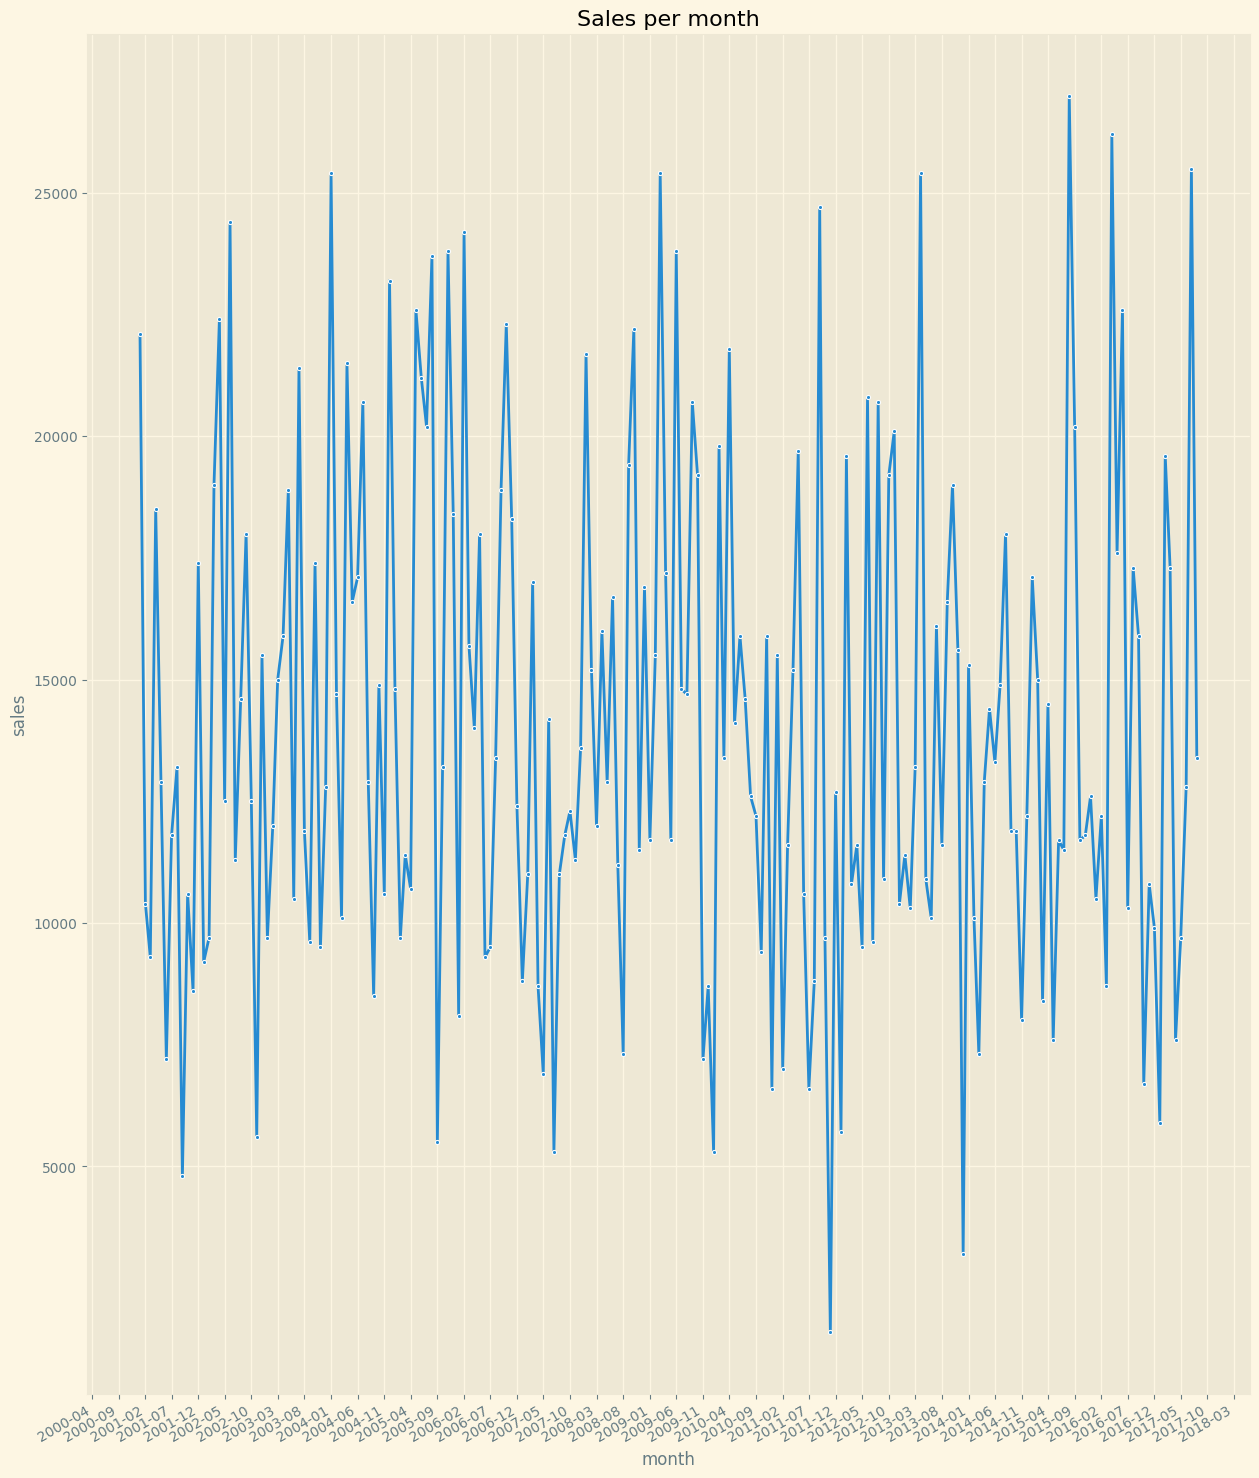

In [51]:
from matplotlib.dates import DateFormatter, MonthLocator, DayLocator

fig, ax = plt.subplots(figsize=(15,20))
sns.lineplot(x=raw_df['Time'].dt.to_timestamp(), y='sales', data=raw_df, ax=ax)

ax.xaxis.set_major_locator(MonthLocator(interval=5))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m')) # Year-Month format
ax.set(title="Sales per month", xlabel="month", ylabel="sales");

fig.autofmt_xdate() # Still useful for rotating labels
plt.show()

No seasonal component makes itself readily apparent to the naked eye looking at sales over time.

### Outliers

<Axes: >

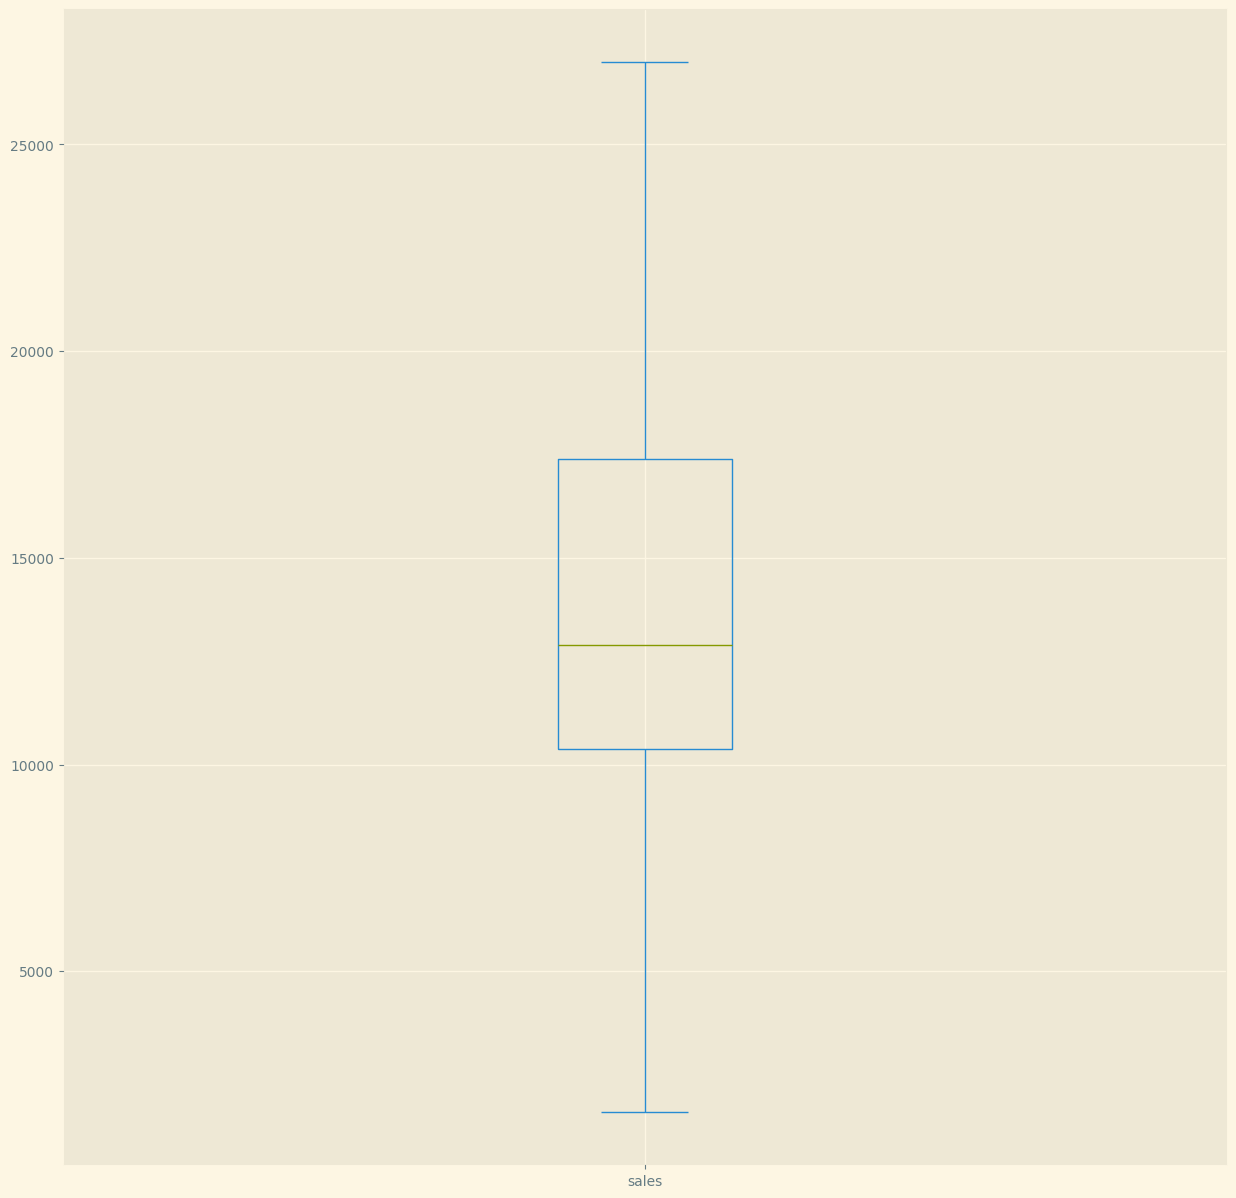

In [52]:
raw_df['sales'].plot.box(figsize=(15, 15))

<Axes: >

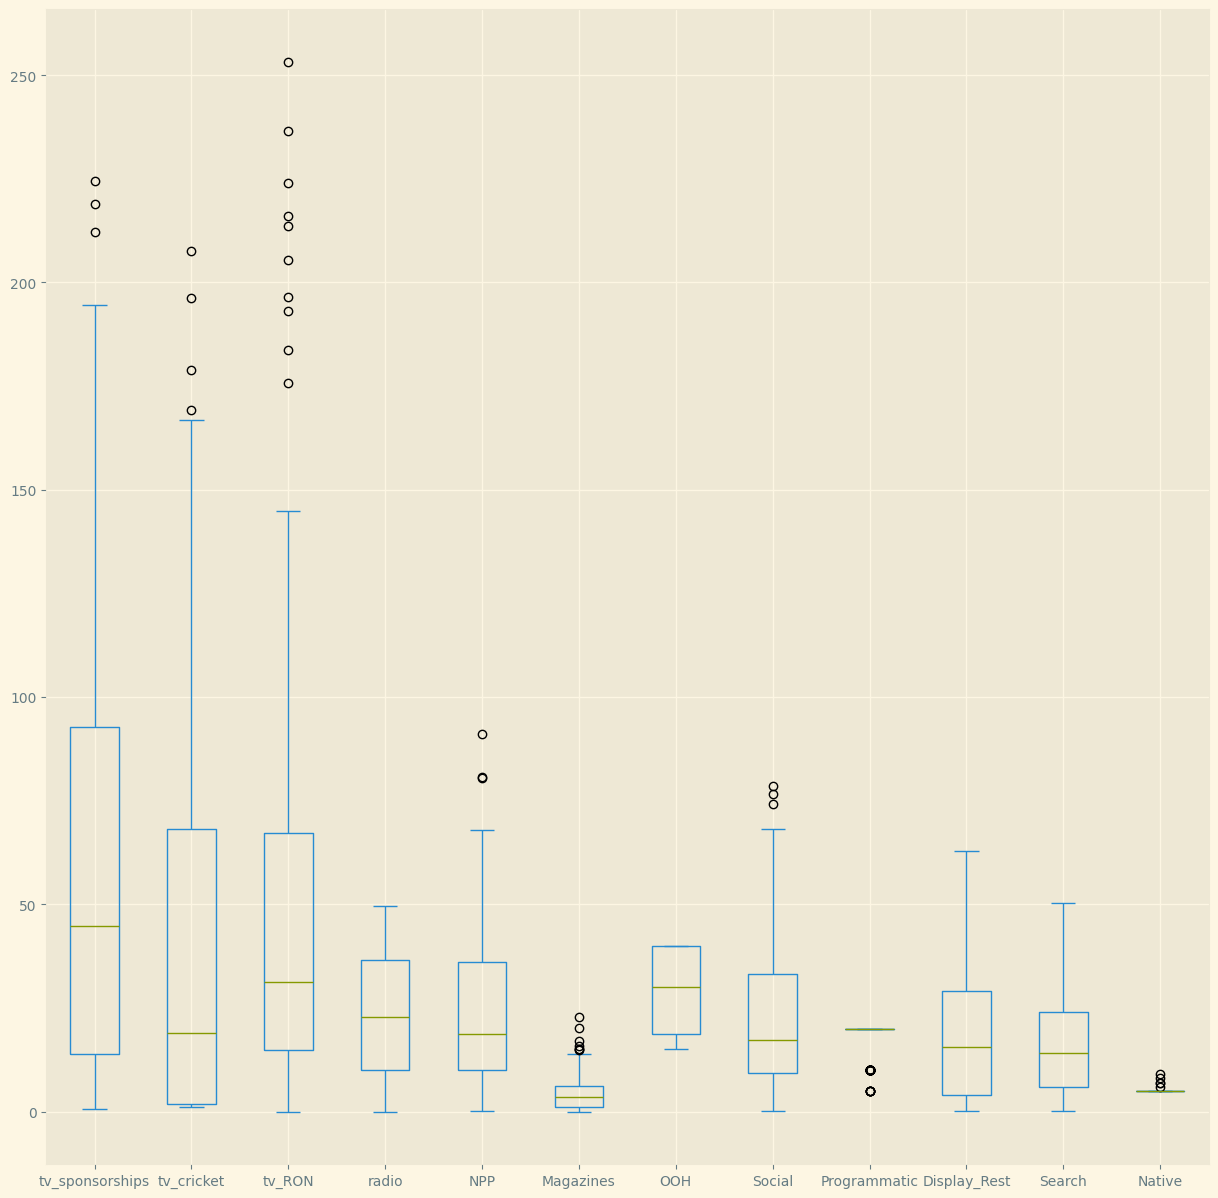

In [53]:
raw_df.drop('sales', axis=1).plot.box(figsize=(15, 15))

Let us now bring in some data on Singapore holidays as that may have some additional impact on sales. The next few cells will create a table of singaporean holiday dates and we will then combine that into a column that will yeild the number of holidays in a given month.

In [54]:
sg_holidays = [(d,h) for d,h in ho.SG(years=range(2001, 2018), observed=False).items()]
sg_ho_df = pd.DataFrame(sg_holidays, columns=['date', 'holiday'])
sg_ho_df['date'] = pd.to_datetime(sg_ho_df['date']).dt.to_period('M')
sg_ho_df.head()
#sg_ho_df.groupby('date')['holiday'].sum()

date           holiday
0  2016-01    New Year's Day
1  2016-02  Chinese New Year
2  2016-02  Chinese New Year
3  2016-07       Eid al-Fitr
4  2016-09       Eid al-Adha

In [55]:
cpi_df.head()

period  cpi_all_raw
0  2001-01         64.8
1  2001-02         64.7
2  2001-03         64.8
3  2001-04         65.0
4  2001-05         64.7

In [56]:
sg_ho_du_df = pd.get_dummies(sg_ho_df, columns=['holiday'], prefix='', prefix_sep='', dtype=int).sort_values(by='date').drop_duplicates().groupby(['date'], as_index=False).sum()

In [57]:
holiday_names = sg_ho_du_df.iloc[:,1:].columns.tolist()

In [58]:
#to make sure there are no non-binary variables in error
for col in sg_ho_du_df:
    print(sg_ho_du_df[col].unique())

<PeriodArray>
['2001-01', '2001-03', '2001-04', '2001-05', '2001-08', '2001-11', '2001-12',
 '2002-01', '2002-02', '2002-03',
 ...
 '2016-10', '2016-12', '2017-01', '2017-04', '2017-05', '2017-06', '2017-08',
 '2017-09', '2017-10', '2017-12']
Length: 131, dtype: period[M]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]


In [59]:
data_df = raw_df.merge(sg_ho_du_df, how='left', left_on='Time', right_on='date').drop('date', axis=1).fillna(0)
data_df = data_df.merge(cpi_df, how='left', left_on='Time', right_on='period').drop('period', axis=1)
data_df.head()

Time  tv_sponsorships  tv_cricket  tv_RON  radio    NPP  Magazines  OOH  \
0  2001-01          119.652      66.729  43.719   37.8  55.36      13.84   35   
1  2001-02           23.140      12.905   8.455   39.3  36.08       9.02   35   
2  2001-03            8.944       4.988   3.268   45.9  55.44      13.86   35   
3  2001-04           78.780      43.935  28.785   41.3  46.80      11.70   35   
4  2001-05           94.016      52.432  34.352   10.8  46.72      11.68   35   

    Social  Programmatic  ...  Eid al-Adha  Eid al-Fitr  Good Friday  \
0  41.8782             5  ...          0.0          0.0          0.0   
1   8.0990             5  ...          0.0          0.0          0.0   
2   3.1304             5  ...          1.0          0.0          0.0   
3  27.5730             5  ...          0.0          0.0          1.0   
4  32.9056             5  ...          0.0          0.0          0.0   

   Labor Day  National Day  New Year's Day  Polling Day  SG50 Public Holiday  \
0        0.0           0.0             1.0          0.0                  0.0   
1        0.0           0.0             0.0          0.0                  0.0   
2        0.0           0.0             0.0          0.0                  0.0   
3        0.0           0.0             0.0          0.0                  0.0   
4        1.0           0.0             0.0          0.0                  0.0   

   Vesak Day  cpi_all_raw  
0        0.0         64.8  
1        0.0         64.7  
2        0.0         64.8  
3        0.0         65.0  
4        1.0         64.7  

[5 rows x 27 columns]

In [60]:
#Do I need all of the figures presented here to make my case?

total_spend_per_channel =raw_df[['tv_sponsorships','tv_cricket','tv_RON',
    'radio','NPP','Magazines','OOH','Social','Programmatic','Display_Rest','Search','Native']].sum(axis=0)
total_revenue = raw_df.sales.sum()
spend_ratio = total_spend_per_channel / total_spend_per_channel.sum()
print(total_revenue)
print(total_spend_per_channel)
print(total_revenue / total_spend_per_channel)


2804500
tv_sponsorships    11902.478000
tv_cricket          8331.473000
tv_RON             10228.611000
radio               4652.800000
NPP                 4874.540000
Magazines            908.660000
OOH                 5870.000000
Social              4385.001900
Programmatic        3530.000000
Display_Rest        3618.176560
Search              3132.833984
Native              1012.000000
dtype: float64
tv_sponsorships     235.623204
tv_cricket          336.615146
tv_RON              274.181900
radio               602.755330
NPP                 575.336339
Magazines          3086.412960
OOH                 477.768313
Social              639.566428
Programmatic        794.475921
Display_Rest        775.114192
Search              895.195856
Native             2771.245059
dtype: float64


### Preparing to build model

In [61]:
print(spend_ratio)


tv_sponsorships    0.190603
tv_cricket         0.133418
tv_RON             0.163798
radio              0.074508
NPP                0.078059
Magazines          0.014551
OOH                0.094000
Social             0.070220
Programmatic       0.056528
Display_Rest       0.057940
Search             0.050168
Native             0.016206
dtype: float64


In [62]:
p_sigmas = 12 * spend_ratio.to_numpy()

p_sigmas.tolist()

[2.2872309213387667,
 1.6010113747657468,
 1.9655735017150082,
 0.8941018862462939,
 0.9367123900840373,
 0.17461197987374427,
 1.1280042280488618,
 0.8426406615336102,
 0.6783398509390941,
 0.6952842346690437,
 0.6020187358990051,
 0.19447023488678844]

## Modeling

This model will be using the PYMC-Marketing package to generate a baysian model of our data. 

In [63]:

from sklearn.preprocessing import MaxAbsScaler

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

import arviz as az 
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz as gr

In [64]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

As pymc-marketing automatically scales channel and target variables between 1 and zero using scikit-learn MaxAbsScaler but leaves all other variable scaling to the discretion of the user, I will apply the same scaling to our CPI data to ensure the model will perform properly.

In [65]:
scaler = MaxAbsScaler()
data_df['cpi_all_raw'] = scaler.fit_transform(data_df[['cpi_all_raw']])
data_df.rename(columns={'cpi_all_raw':'cpi'}, inplace=True)
data_df.head()

Time  tv_sponsorships  tv_cricket  tv_RON  radio    NPP  Magazines  OOH  \
0  2001-01          119.652      66.729  43.719   37.8  55.36      13.84   35   
1  2001-02           23.140      12.905   8.455   39.3  36.08       9.02   35   
2  2001-03            8.944       4.988   3.268   45.9  55.44      13.86   35   
3  2001-04           78.780      43.935  28.785   41.3  46.80      11.70   35   
4  2001-05           94.016      52.432  34.352   10.8  46.72      11.68   35   

    Social  Programmatic  ...  Eid al-Adha  Eid al-Fitr  Good Friday  \
0  41.8782             5  ...          0.0          0.0          0.0   
1   8.0990             5  ...          0.0          0.0          0.0   
2   3.1304             5  ...          1.0          0.0          0.0   
3  27.5730             5  ...          0.0          0.0          1.0   
4  32.9056             5  ...          0.0          0.0          0.0   

   Labor Day  National Day  New Year's Day  Polling Day  SG50 Public Holiday  \
0        0.0           0.0             1.0          0.0                  0.0   
1        0.0           0.0             0.0          0.0                  0.0   
2        0.0           0.0             0.0          0.0                  0.0   
3        0.0           0.0             0.0          0.0                  0.0   
4        1.0           0.0             0.0          0.0                  0.0   

   Vesak Day       cpi  
0        0.0  0.756126  
1        0.0  0.754959  
2        0.0  0.756126  
3        0.0  0.758460  
4        1.0  0.754959  

[5 rows x 27 columns]

Before building the model, we need to define the sigmas for or half normal priors that we are fitting to these data. These priors will use their share of overall spend to give greater flexibility of influence  over the target variable to those that have more spending.

In [66]:
data_df['Time'] = data_df['Time'].dt.to_timestamp() #needed as pymc-marketing cannot work with period data types


In [67]:
x = data_df.drop(['sales'], axis=1) #while the other variables will be pulled from data_df, it was easier to write these steps using the raw_df
y = data_df['sales']

In [68]:
x.head()

Time  tv_sponsorships  tv_cricket  tv_RON  radio    NPP  Magazines  \
0 2001-01-01          119.652      66.729  43.719   37.8  55.36      13.84   
1 2001-02-01           23.140      12.905   8.455   39.3  36.08       9.02   
2 2001-03-01            8.944       4.988   3.268   45.9  55.44      13.86   
3 2001-04-01           78.780      43.935  28.785   41.3  46.80      11.70   
4 2001-05-01           94.016      52.432  34.352   10.8  46.72      11.68   

   OOH   Social  Programmatic  ...  Eid al-Adha  Eid al-Fitr  Good Friday  \
0   35  41.8782             5  ...          0.0          0.0          0.0   
1   35   8.0990             5  ...          0.0          0.0          0.0   
2   35   3.1304             5  ...          1.0          0.0          0.0   
3   35  27.5730             5  ...          0.0          0.0          1.0   
4   35  32.9056             5  ...          0.0          0.0          0.0   

   Labor Day  National Day  New Year's Day  Polling Day  SG50 Public Holiday  \
0        0.0           0.0             1.0          0.0                  0.0   
1        0.0           0.0             0.0          0.0                  0.0   
2        0.0           0.0             0.0          0.0                  0.0   
3        0.0           0.0             0.0          0.0                  0.0   
4        1.0           0.0             0.0          0.0                  0.0   

   Vesak Day       cpi  
0        0.0  0.756126  
1        0.0  0.754959  
2        0.0  0.756126  
3        0.0  0.758460  
4        1.0  0.754959  

[5 rows x 26 columns]

In [69]:
mmm_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=p_sigmas),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [70]:
mmm_sampler_config = {"progressbar": True, 'tune': 2000}

In [71]:
#starting off in this instance by assuming that  the effect of an advertizing channel maximizes at exposure and dwindles overtime. Hence the geometric adstock feature.

mmm = MMM(
    model_config=mmm_model_config,
    sampler_config=mmm_sampler_config,
    date_column='Time',
    adstock=GeometricAdstock(l_max=2), #this variable assumes the time window for an ad to hav maximum effect and dwindle  there after. 
    #8 weeks being standard so 2 periods with our monthly data
    saturation=LogisticSaturation(),
    channel_columns=['tv_sponsorships','tv_cricket','tv_RON',
    'radio','NPP','Magazines','OOH','Social','Programmatic','Display_Rest','Search','Native'],
    control_columns = holiday_names +['cpi'],
)

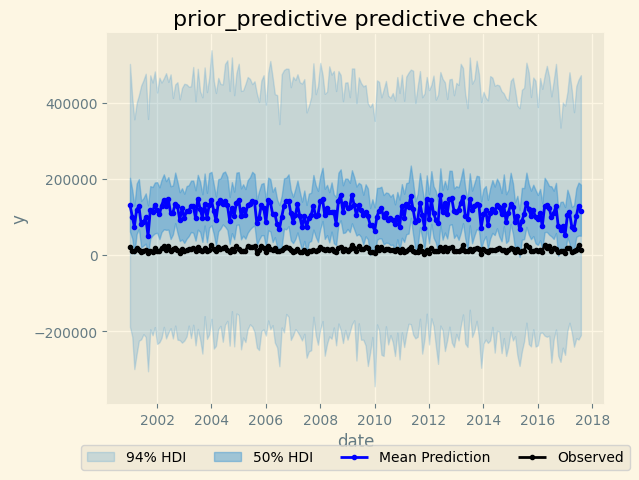

In [72]:
# Generate prior predictive samples to asses if the model is not too similar to the data before it is set to predict the data
mmm.sample_prior_predictive(x, y, samples=2_000)

fig, ax = plt.subplots()
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

In [73]:
# Make sure to check https://github.com/jax-ml/jax?tab=readme-ov-file#installation on registering my gpu for this

mmm.fit(X=x, y=y, chains=4, target_accept=0.85, nuts_sampler="blackjax", random_seed=rng)

Running window adaptation


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

my model has a divergence so lets keep a close ey on the other diagnostics.

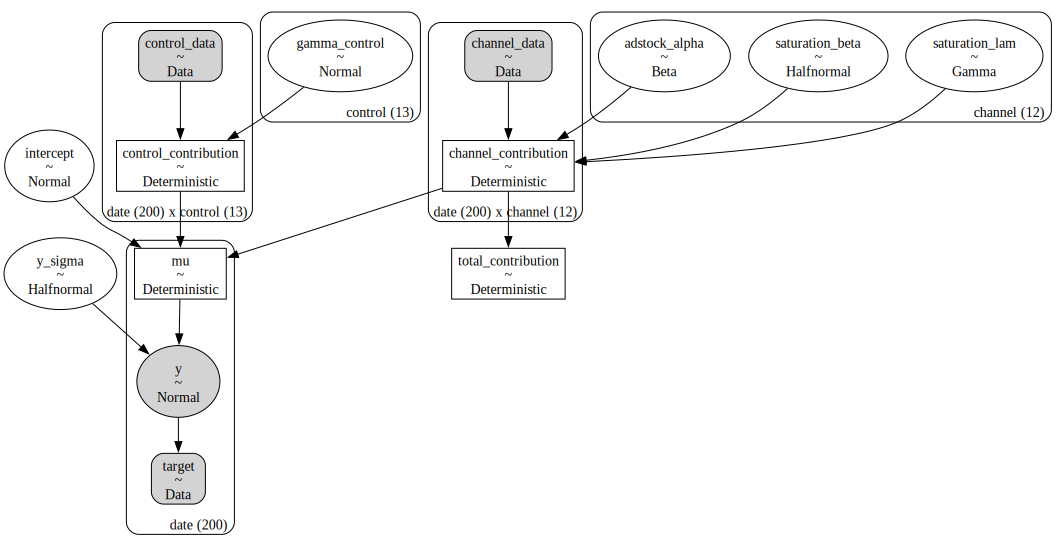

In [74]:
mmm.graphviz()

an explanatory graphic of my model. This is useful more on the analyst end than the client end to determine how the various parts of the model relate to one another and if it is specified properly. Meanwhile, I shall begin a diagnostic.

In [75]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                          -0.089  0.060  -0.201    0.019      0.001   
y_sigma                             0.060  0.003   0.054    0.066      0.000   
saturation_beta[tv_sponsorships]    0.394  0.217   0.176    0.631      0.008   
saturation_beta[tv_cricket]         0.299  0.105   0.208    0.435      0.005   
saturation_beta[tv_RON]             0.249  0.031   0.200    0.307      0.001   
saturation_beta[radio]              0.958  0.330   0.469    1.572      0.007   
saturation_beta[NPP]                0.030  0.058   0.000    0.087      0.001   
saturation_beta[Magazines]          0.026  0.031   0.000    0.080      0.001   
saturation_beta[OOH]                0.023  0.033   0.000    0.064      0.001   
saturation_beta[Social]             0.056  0.089   0.000    0.181      0.002   
saturation_beta[Programmatic]       0.160  0.105   0.037    0.349      0.003   
saturation_beta[Display_Rest]       0.059  0.079   0.000    0.179      0.002   
saturation_beta[Search]             0.037  0.062   0.000    0.112      0.001   
saturation_beta[Native]             0.060  0.057   0.000    0.162      0.001   
saturation_lam[tv_sponsorships]     2.449  0.858   0.887    4.067      0.020   
saturation_lam[tv_cricket]          3.701  1.141   1.465    5.873      0.033   
saturation_lam[tv_RON]              5.430  1.470   2.859    8.207      0.035   
saturation_lam[radio]               0.867  0.302   0.356    1.439      0.006   
saturation_lam[NPP]                 2.303  1.641   0.056    5.247      0.023   
saturation_lam[Magazines]           2.208  1.487   0.136    4.954      0.023   
saturation_lam[OOH]                 3.235  2.177   0.142    7.153      0.033   
saturation_lam[Social]              2.169  1.548   0.071    4.972      0.023   
saturation_lam[Programmatic]        1.984  1.171   0.205    4.077      0.022   
saturation_lam[Display_Rest]        2.189  1.565   0.106    5.115      0.024   
saturation_lam[Search]              2.250  1.647   0.076    5.117      0.024   
saturation_lam[Native]              2.706  1.798   0.113    5.937      0.025   
adstock_alpha[tv_sponsorships]      0.022  0.022   0.000    0.061      0.000   
adstock_alpha[tv_cricket]           0.098  0.071   0.000    0.221      0.001   
adstock_alpha[tv_RON]               0.028  0.028   0.000    0.080      0.000   
adstock_alpha[radio]                0.027  0.023   0.000    0.068      0.000   
adstock_alpha[NPP]                  0.247  0.191   0.000    0.598      0.003   
adstock_alpha[Magazines]            0.252  0.193   0.000    0.606      0.002   
adstock_alpha[OOH]                  0.251  0.195   0.000    0.617      0.003   
adstock_alpha[Social]               0.186  0.168   0.000    0.516      0.002   
adstock_alpha[Programmatic]         0.255  0.191   0.000    0.605      0.003   
adstock_alpha[Display_Rest]         0.175  0.164   0.000    0.490      0.002   
adstock_alpha[Search]               0.210  0.181   0.000    0.559      0.002   
adstock_alpha[Native]               0.251  0.190   0.000    0.599      0.002   
gamma_control[Chinese New Year]     0.007  0.016  -0.020    0.039      0.000   
gamma_control[Christmas Day]        0.003  0.016  -0.027    0.033      0.000   
gamma_control[Deepavali]            0.006  0.016  -0.022    0.037      0.000   
gamma_control[Eid al-Adha]         -0.030  0.015  -0.057   -0.000      0.000   
gamma_control[Eid al-Fitr]          0.013  0.015  -0.015    0.041      0.000   
gamma_control[Good Friday]         -0.003  0.015  -0.031    0.025      0.000   
gamma_control[Labor Day]            0.005  0.025  -0.039    0.052      0.000   
gamma_control[National Day]         0.017  0.015  -0.014    0.044      0.000   
gamma_control[New Year's Day]       0.011  0.016  -0.017    0.043      0.000   
gamma_control[Polling Day]          0.016  0.028  -0.038    0.067      0.000   
gamma_control[SG50 Public Holiday]  0.050  0.040  -0.023    0.125      0.001   
gamma_control[Vesak Day]           -0

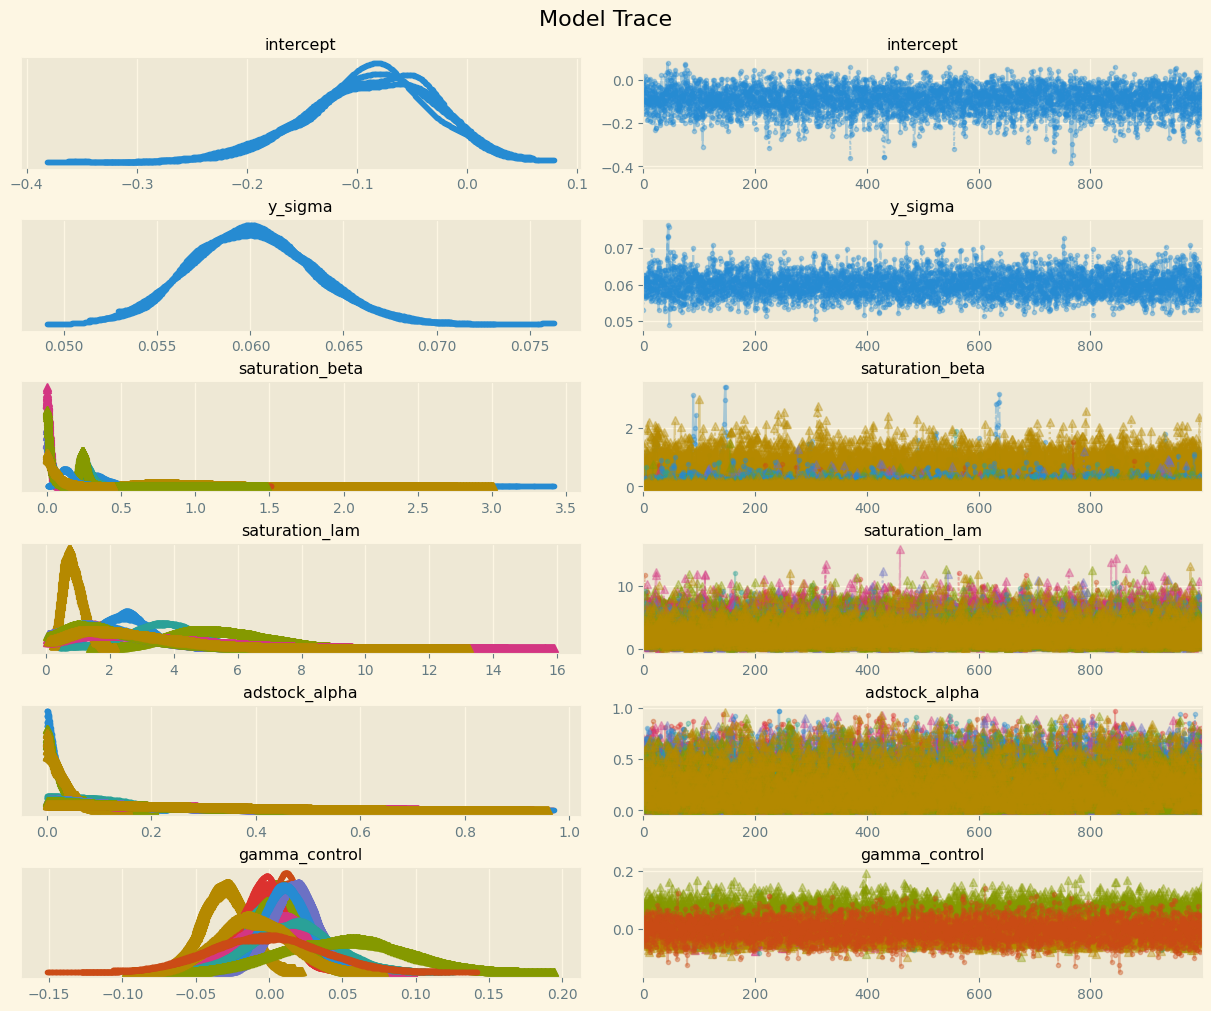

In [76]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
   ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [77]:
mmm.sample_posterior_predictive(x, extend_idata=True, combined=True)

Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 200)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2017-08-01
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 2.259e+04 1.718e+04 ... 1.615e+04
Attributes:
    created_at:                 2025-09-13T02:38:13.752669+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

Output()

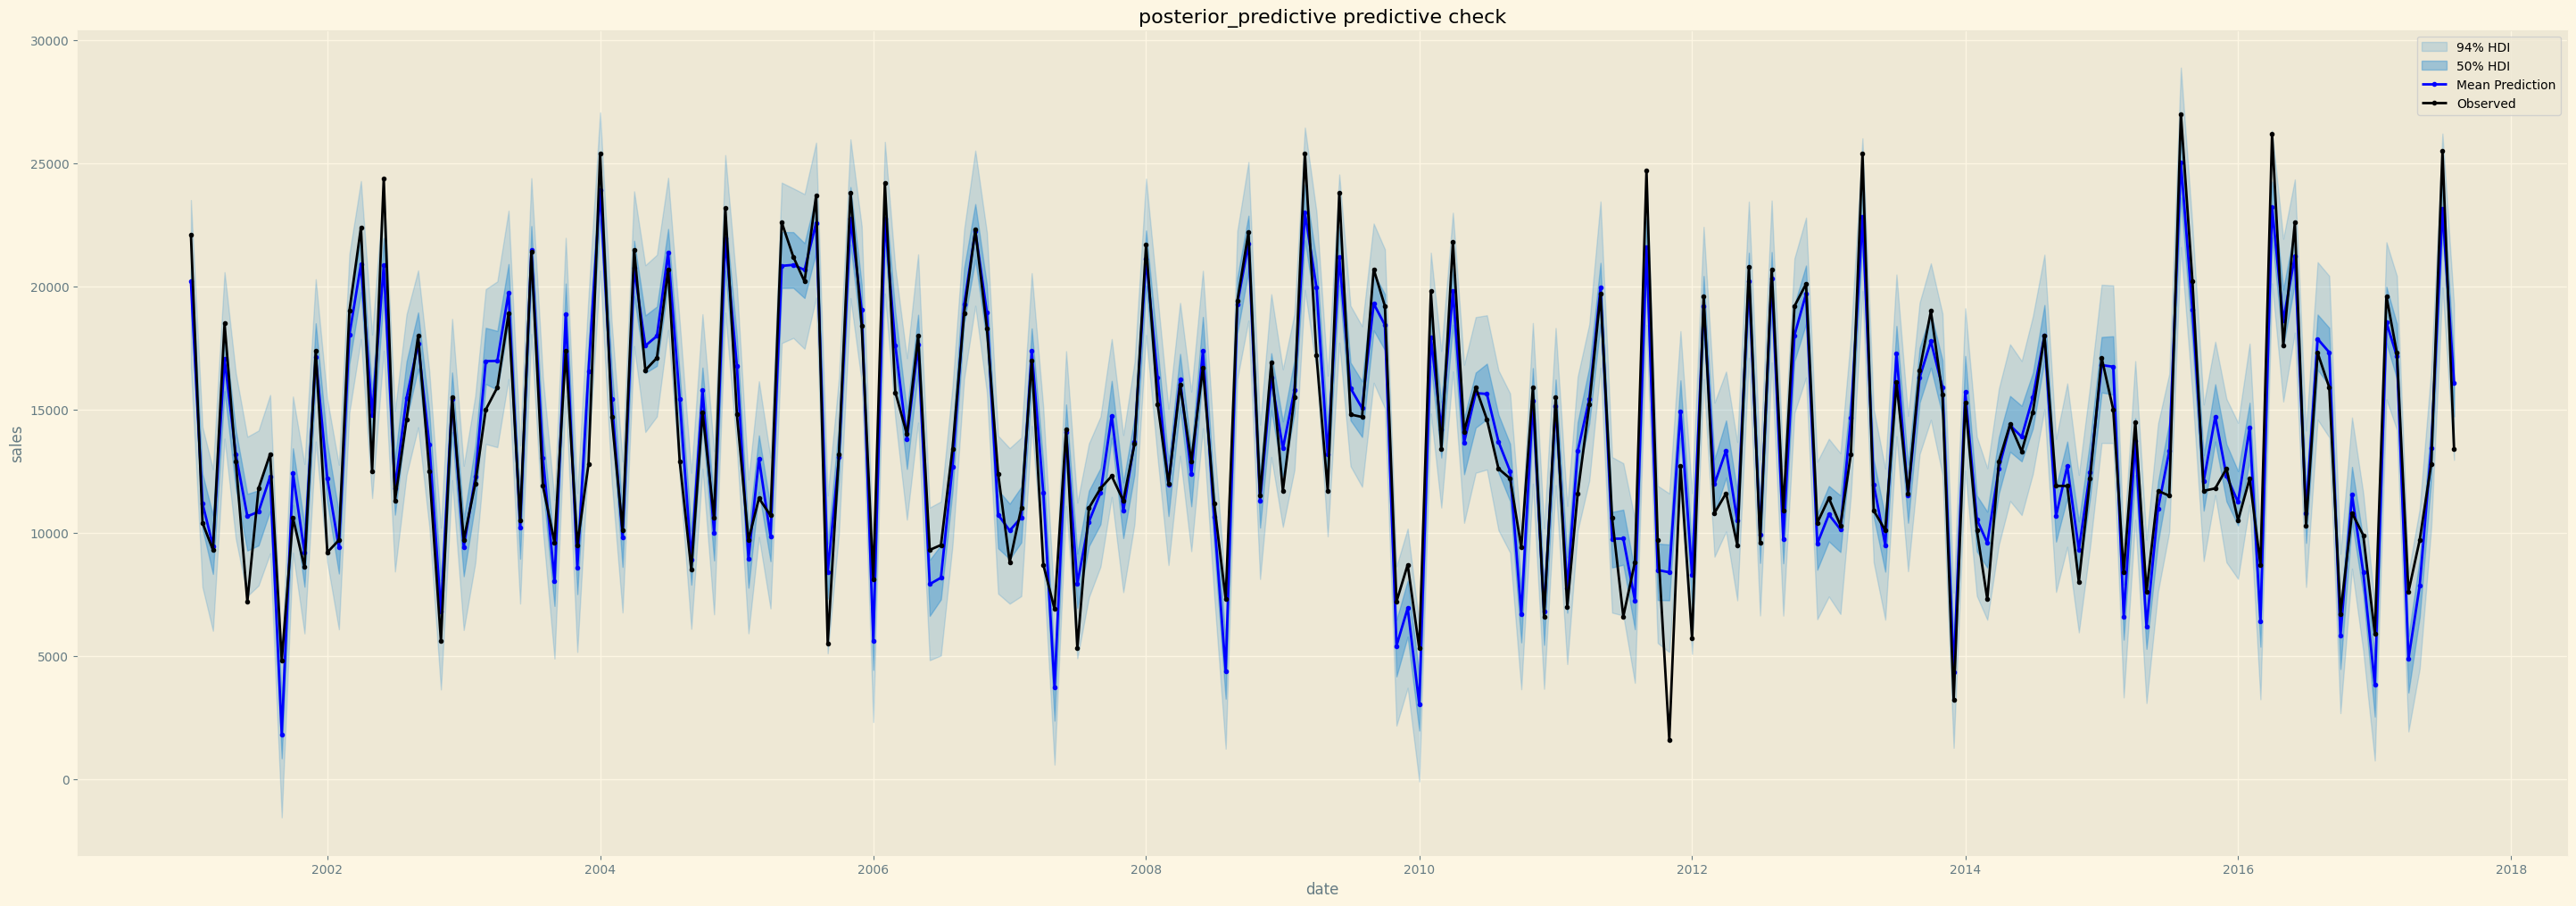

In [78]:
mmm.sample_posterior_predictive(x, extend_idata=True, combined=True)
fig = mmm.plot_posterior_predictive(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales")
fig.set_size_inches(36, 12)

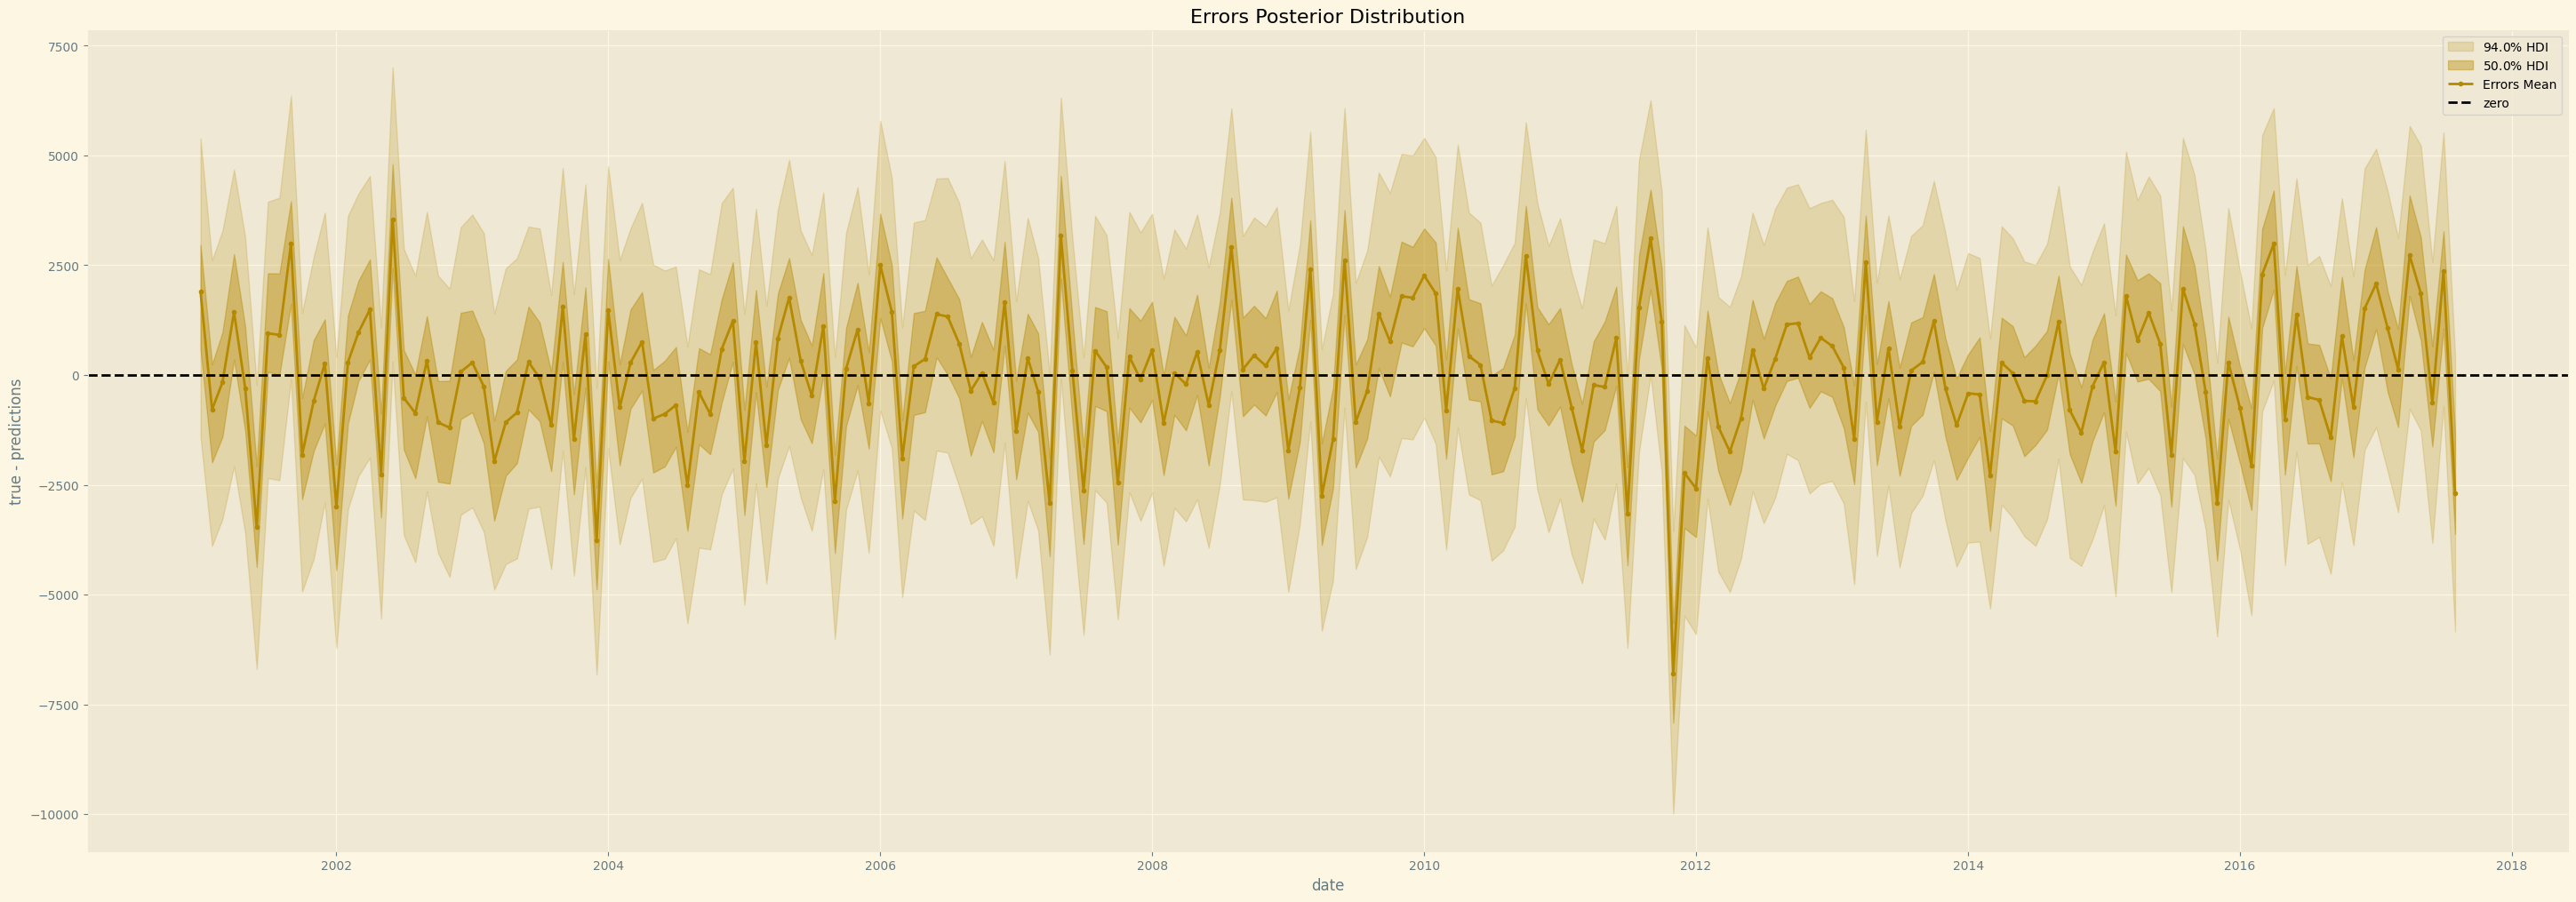

In [79]:
fig = mmm.plot_errors(original_scale=True)
fig.set_size_inches(36, 12)

Looking at R-hat and other model diagnostics does not show any obvious issues with the model so we can continue with this exercise.

## Channel Contributions

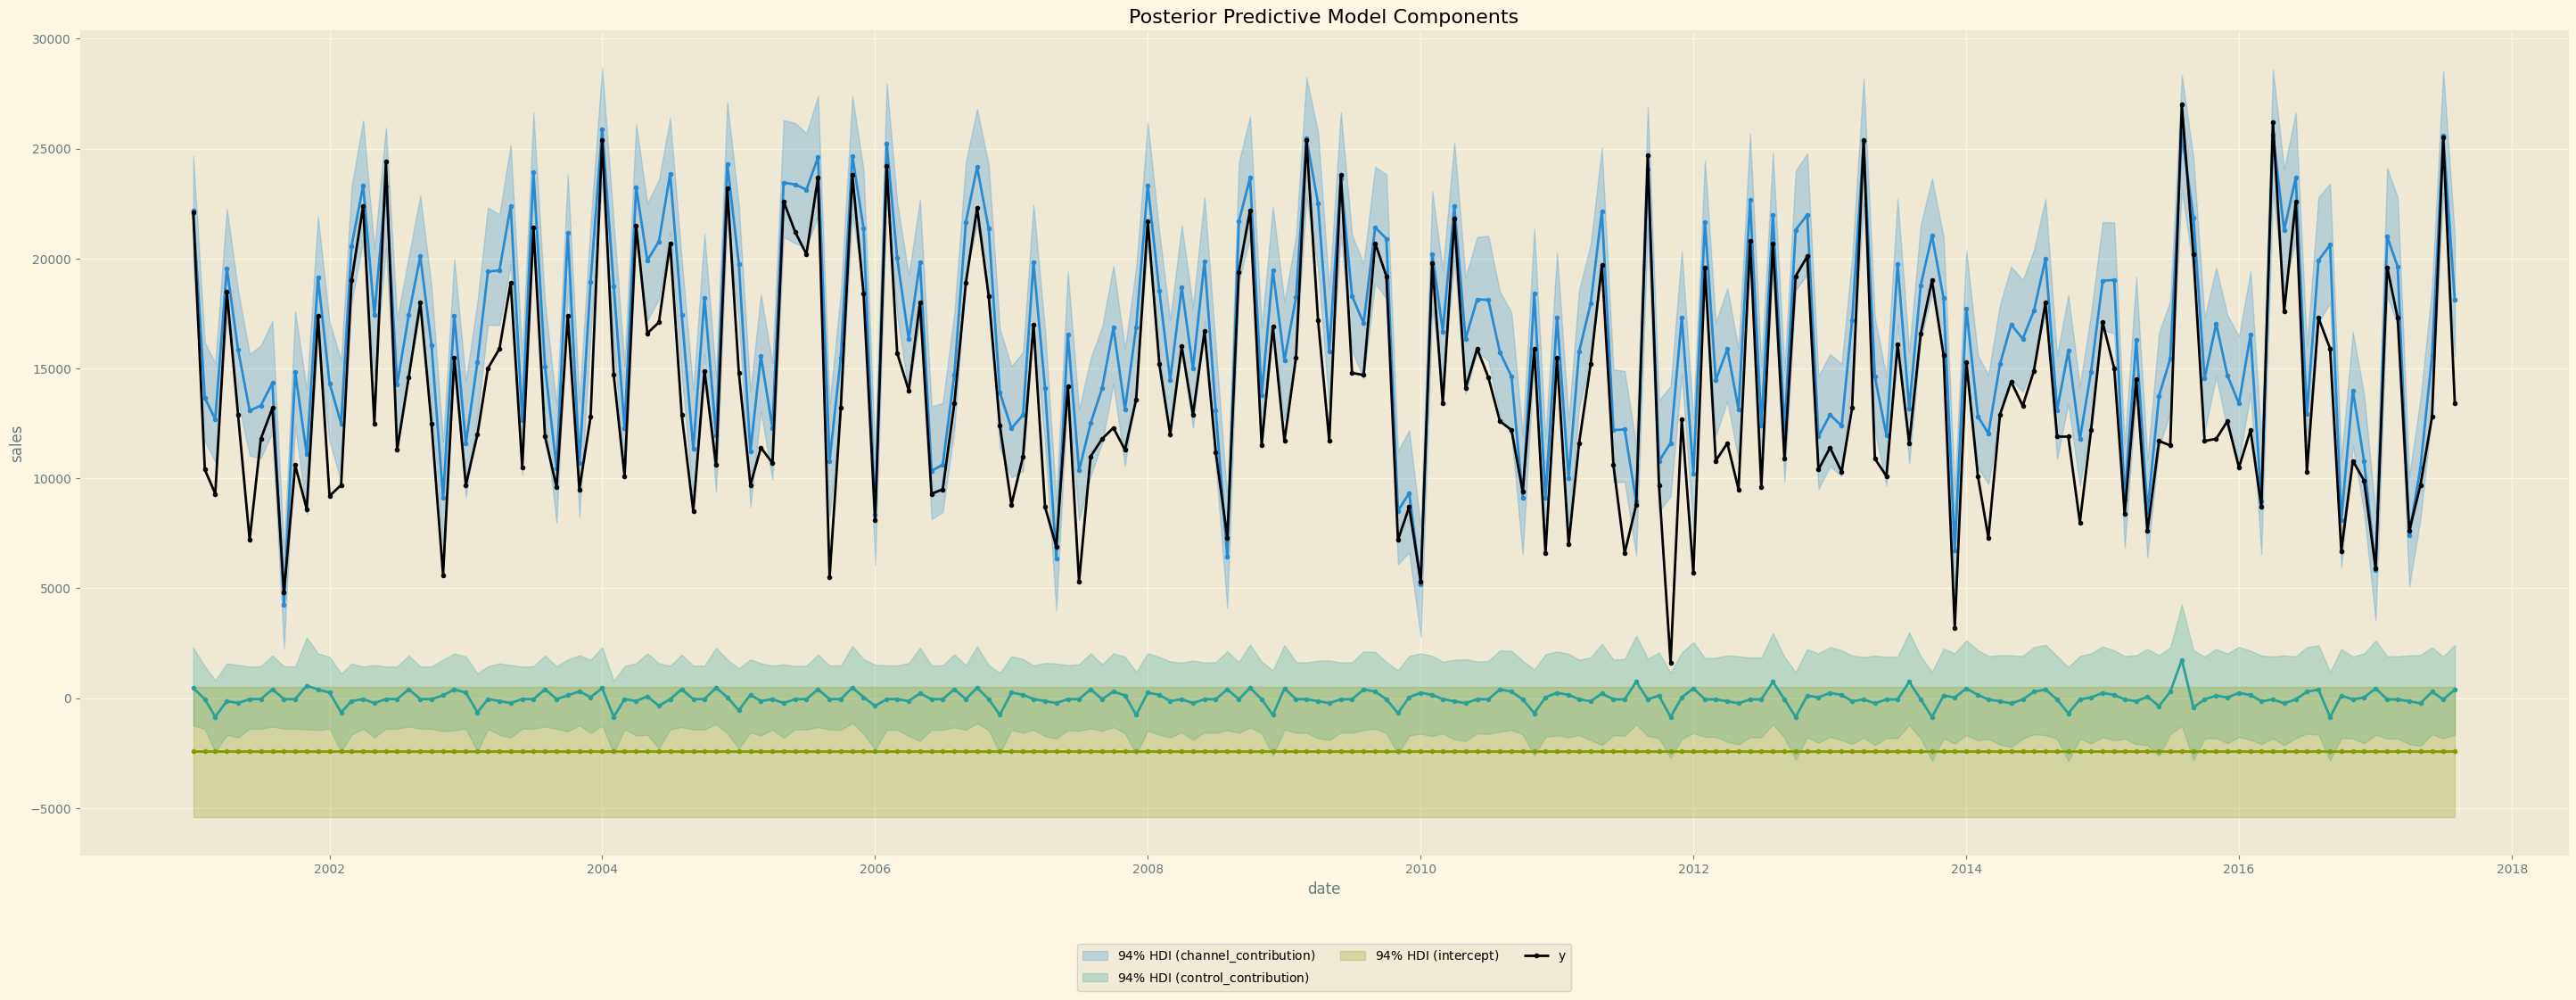

In [80]:
fig = mmm.plot_components_contributions(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales")
fig.set_size_inches(36, 12)

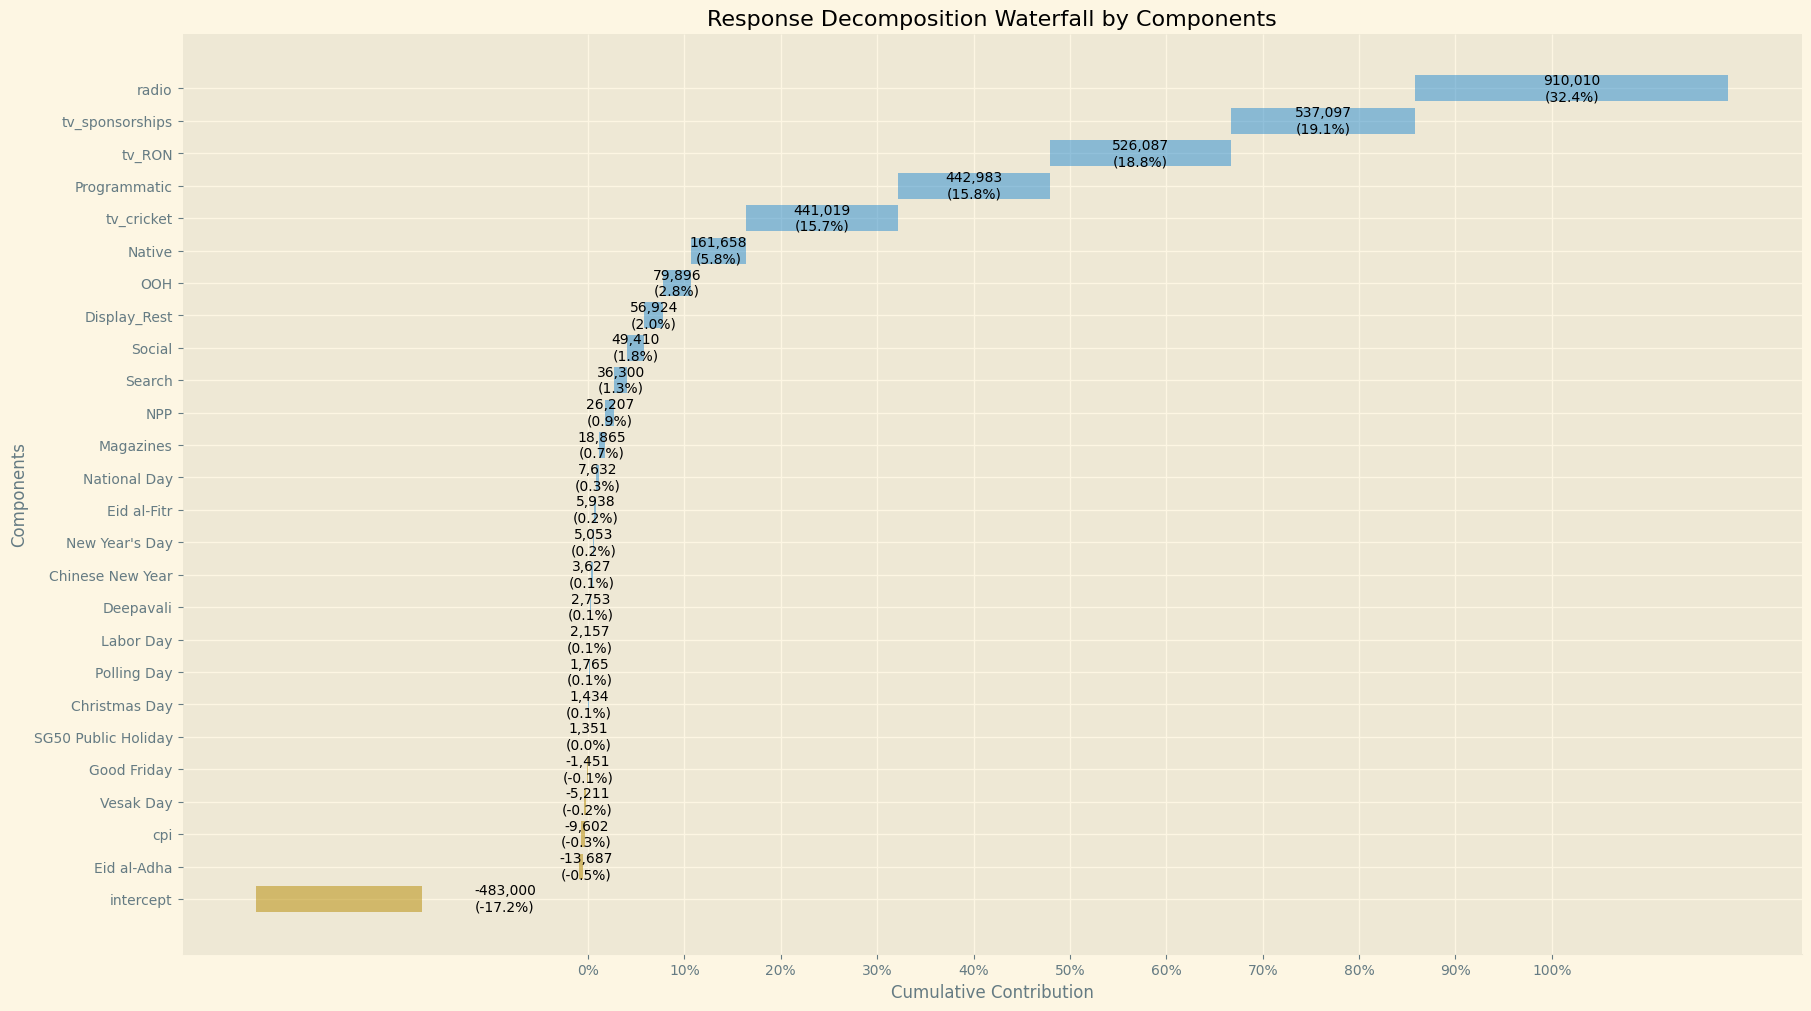

In [81]:
mmm.plot_waterfall_components_decomposition(figsize=(18, 10));

Some interesting observations from this chart:

- All of our channels have a positive attributed to them
- The following holidays have a negative correlation: Eid-al-Adha, Vesak Day, Good Friday, and the Singaporean Celebration of the 50th anniversary of independence. As the first three holidays are religious days involving fasting and prayer for the three largest religious affiliations in Singapore, a negative correlation is not surprising. Given that singaporean independence has some negative correlation as well dos invite questions as to the nature of the product described in these data.
- Given that the intercept has a negative contribution, it would be advisable to discuss with the client what the nature of their product is as either there are other external factors not properly accounted for in these data or there is a strong market bias against the product.


## Saturation Curves

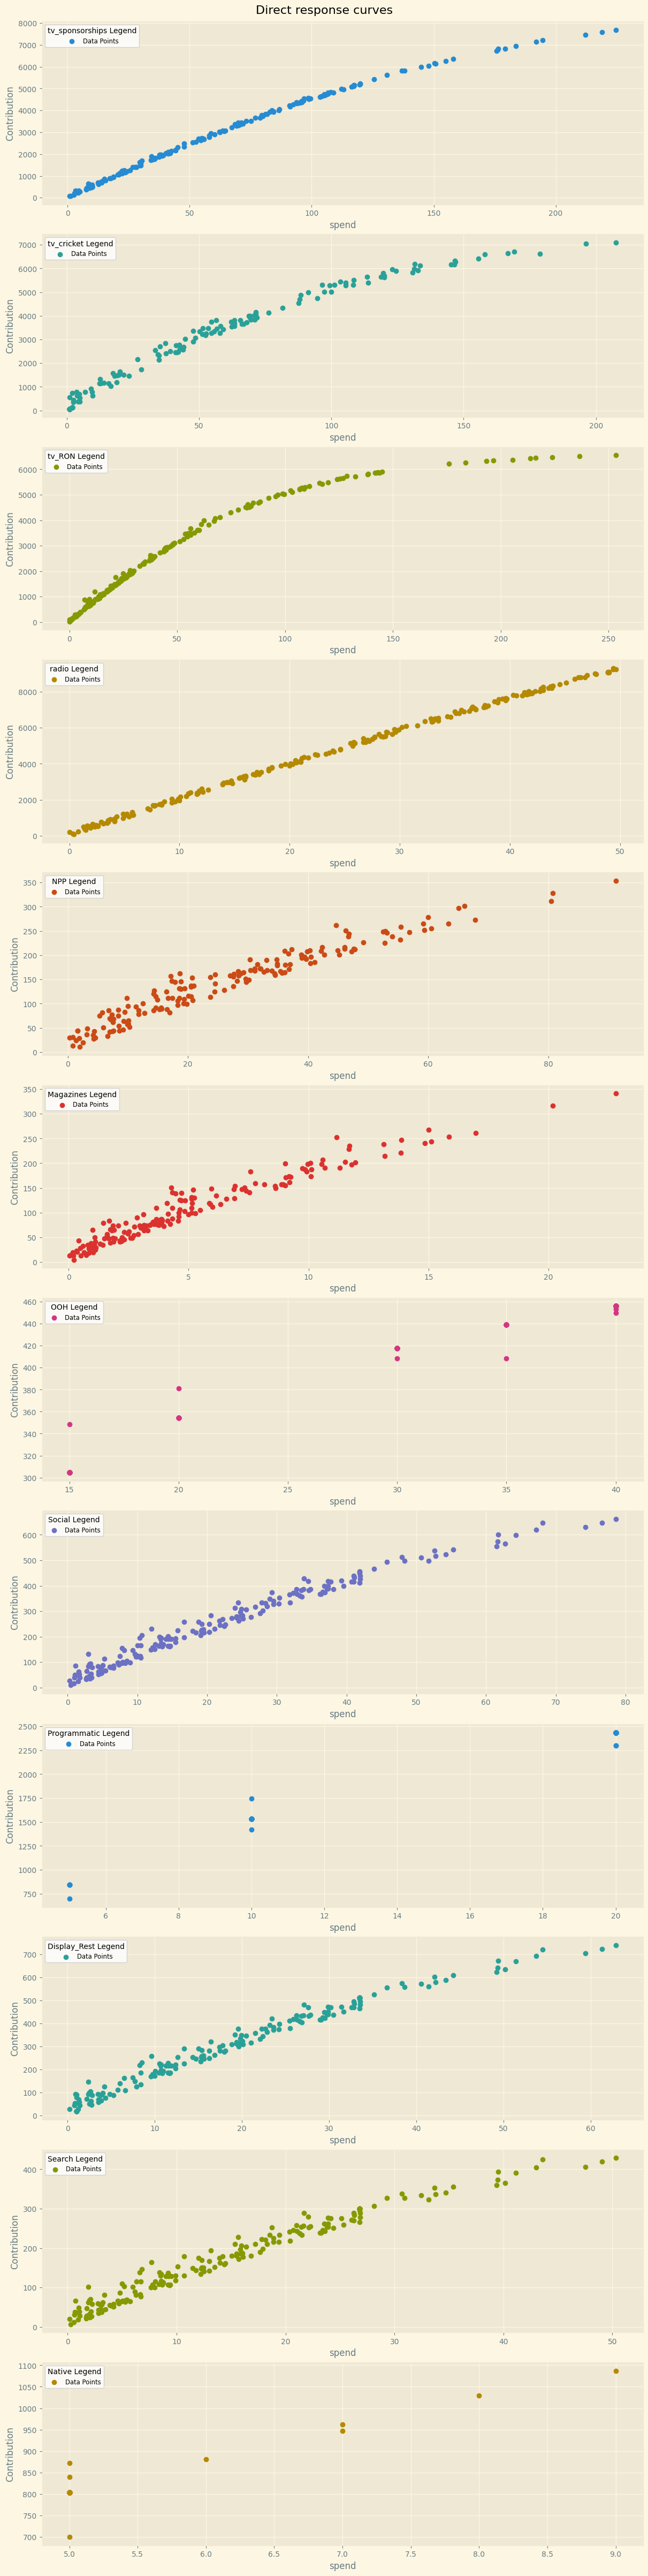

In [90]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="spend") for ax in fig.axes];

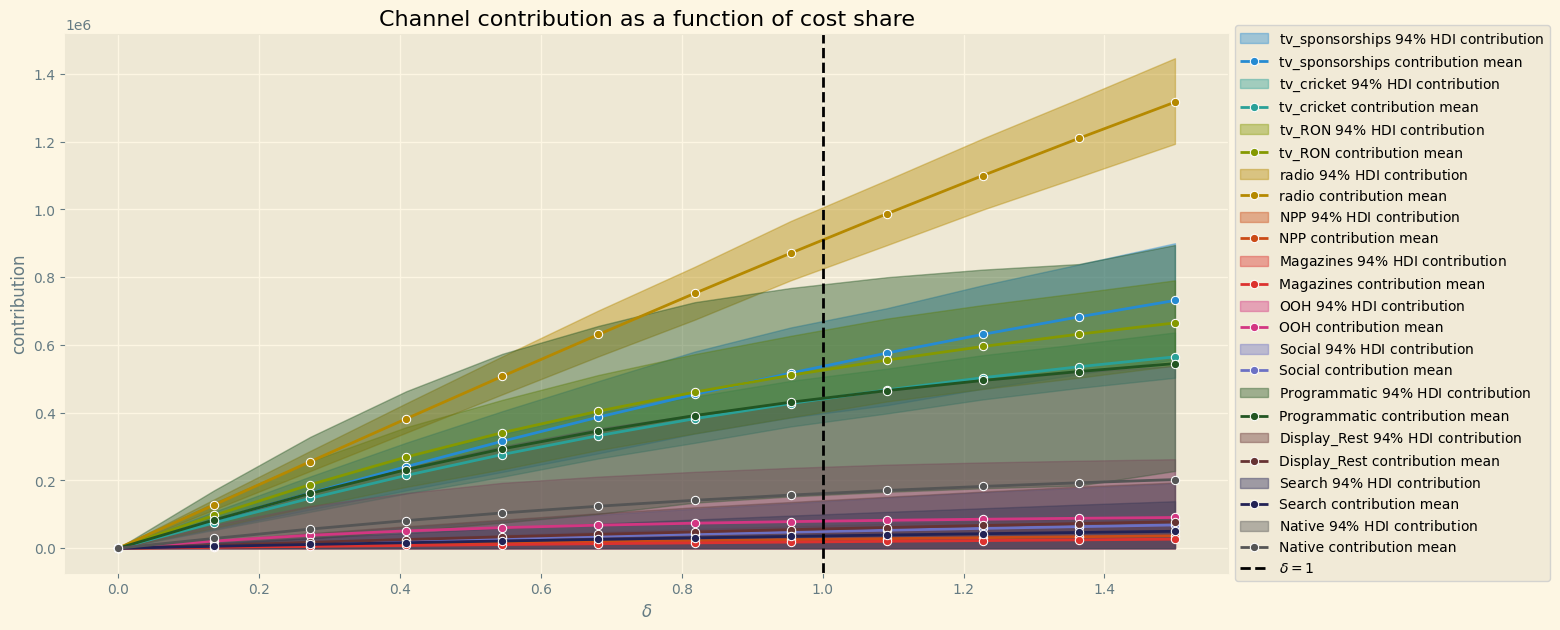

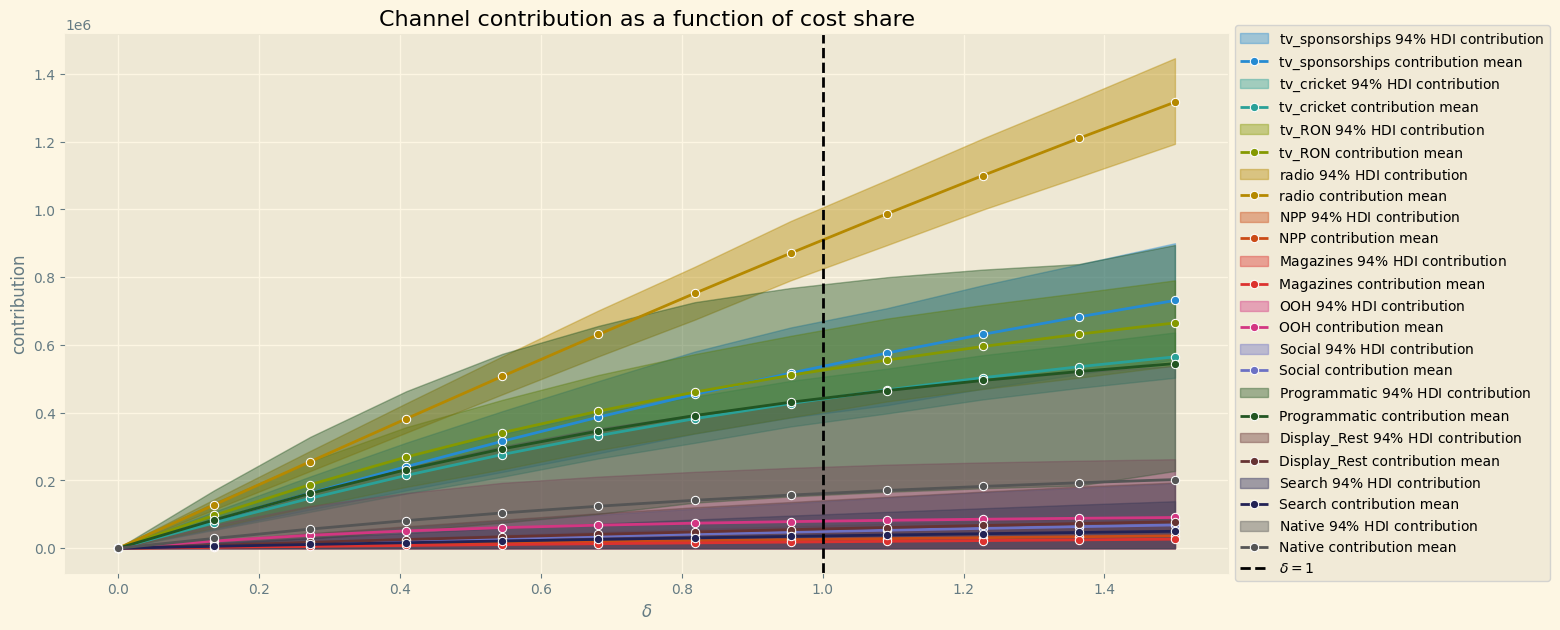

In [95]:
mmm.plot_channel_contribution_grid(start=0, stop=1.5, num=12, figsize=(15, 7))


